In [1]:
!pip install --upgrade transformers accelerate bitsandbytes

## Import libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [4]:
print(torch.cuda.is_available())

False


In [5]:
torch.cuda.is_bf16_supported()

False

## Set config

In [6]:
MAX_SEQUENCE_LENGTH = 512

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
MODEL_NAME = "microsoft/deberta-v3-base"
USE_4BIT = True

LORA_TARGETS = ["query_proj", "key_proj", "value_proj", "dense"]
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05

## Import dataset

In [9]:
import os
os.chdir('/content/')
os.getcwd()

'/content'

In [10]:
raw_df = pd.read_csv("/content/drive/MyDrive/Data Science Projects/llm-finetuning/nlp-playground/data/raw/llm-classification-finetuning/train.csv")
# raw_df = pd.read_csv("./data/raw/llm-classification-finetuning/train.csv")

In [11]:
raw_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


## EDA

In [12]:
raw_df.dtypes

,0
id,int64
model_a,object
model_b,object
prompt,object
response_a,object
response_b,object
winner_model_a,int64
winner_model_b,int64
winner_tie,int64


In [13]:
print(type(raw_df['prompt'].iloc[0]))
print(type(raw_df['response_a'].iloc[0]))
print(type(raw_df['response_b'].iloc[0]))

<class 'str'>
<class 'str'>
<class 'str'>


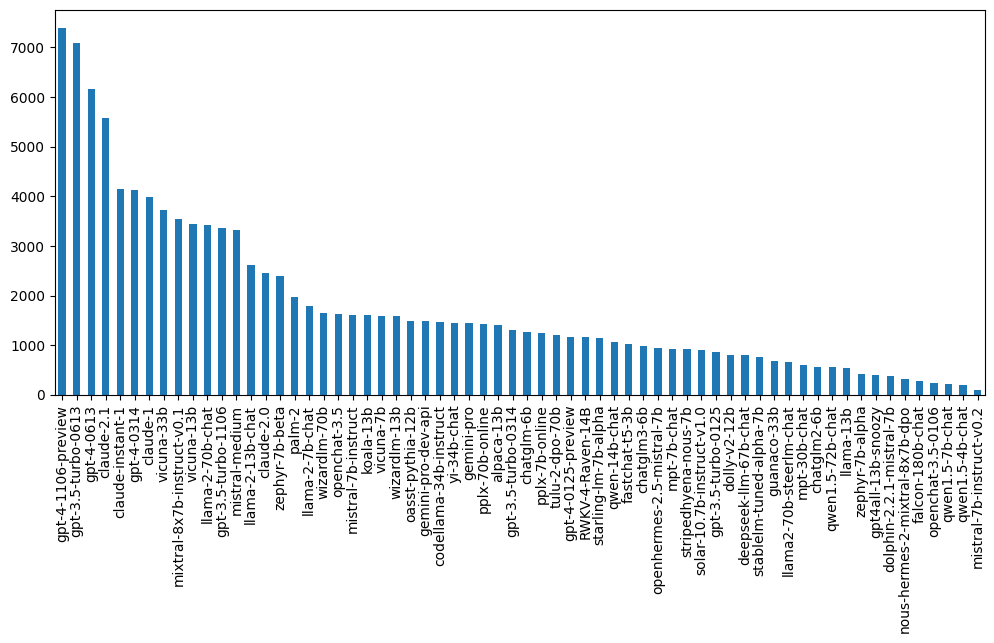

In [14]:
plt.figure(figsize=(12,5))
pd.concat([raw_df['model_a'], raw_df['model_b']]).value_counts().plot(kind='bar', stacked=True)

plt.show()

## Data pre-processing

In [15]:
import json

def safe_parse_json(x):
    if not isinstance(x, str):
        return x
    try:
        val = json.loads(x)
        # If it's a list, return first non-null element
        if isinstance(val, list):
            if val:
                return [item if item is not None else '' for item in val]
            else:
                return ''
        return val
    except json.JSONDecodeError:
        return ""

raw_df["response_a_processed"] = raw_df["response_a"].apply(safe_parse_json)
raw_df["response_b_processed"] = raw_df["response_b"].apply(safe_parse_json)
raw_df["prompt_processed"] = raw_df["prompt"].apply(safe_parse_json)

In [16]:
def format_conversation(query_list, response_list):
    parts = []
    for i, (q, r) in enumerate(zip(query_list, response_list)):
        parts.append((f"Query:\n{q}\n\nResponse:\n{r}"))
    return '\n\n'.join(parts)

raw_df['text_a'] = raw_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_a_processed']), axis=1)
raw_df['text_b'] = raw_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_b_processed']), axis=1)

In [17]:
word_split = raw_df["text_a"].apply(lambda x: x.split(' '))
word_split.apply(lambda x: len(x)).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90])

,text_a
count,57477.000000
mean,274.053343
std,330.512938
min,1.000000
5%,23.000000
25%,91.000000
50%,205.000000
75%,340.000000
90%,536.000000
max,10459.000000


In [18]:
word_split = raw_df["text_b"].apply(lambda x: x.split(' '))
word_split.apply(lambda x: len(x)).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90])

,text_b
count,57477.000000
mean,275.752371
std,347.943182
min,1.000000
5%,23.000000
25%,91.000000
50%,206.000000
75%,340.000000
90%,540.000000
max,20764.000000


The conversations mostly have < 1000 words in each conversation. Assuming $ \text{Tokens per conversation} = 1.5 \times \text{Words per conversation} $, we would ideally need a model which can handle ~1500 tokens. However, to keep the model easy and simpleto train we will use a model with smaller max sequence limit.

In [19]:
def create_target_col(encoding):
    """
    Create column for target labels
    """

    if encoding == [0, 0, 1]:
        return 'tie'
    elif encoding == [0, 1, 0]:
        return 'model_b'
    elif encoding == [1, 0, 0]:
        return 'model_a'

    return np.nan

raw_df['target'] = raw_df[['winner_model_a', 'winner_model_b', 'winner_tie']].apply(lambda x: create_target_col(list(x)), axis=1)

raw_df['label'] = raw_df['target'].map({'model_a': 0, 'model_b': 1, 'tie': 2})

## Setting up modelling architecture

In [20]:
from transformers import (
    AutoTokenizer,
    AutoModel,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
)

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

# Get model for embeddings
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

quant_config = BitsAndBytesConfig(
load_in_4bit=USE_4BIT,
load_in_8bit=not USE_4BIT,
bnb_4bit_quant_type="nf4" if USE_4BIT else None,
bnb_4bit_use_double_quant=True if USE_4BIT else None,
bnb_4bit_compute_dtype=torch.bfloat16 if USE_4BIT and torch.cuda.is_available() else None,
)

backbone = AutoModel.from_pretrained(MODEL_NAME, quantization_config=quant_config, device_map="auto")

# Prepare for k-bit training (fixes layer norms, casts, etc.)
# backbone = prepare_model_for_kbit_training(backbone)

# Apply LoRA
lora_cfg = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=LORA_TARGETS,
    bias="none",
    task_type="SEQ_CLS", # generic; works for encoder models
)

# backbone = get_peft_model(backbone, lora_cfg)

hidden_size = backbone.config.hidden_size

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

In [21]:
assert MAX_SEQUENCE_LENGTH <= backbone.config.max_position_embeddings, f"Config 'max_sequence_length' must be <= the max sequence length allowed by the model i.e. {backbone.config.max_position_embeddings}"

## Create Model Architecture

In [22]:
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
from torch.nn import functional as F

def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    count = mask.sum(dim=1).clamp(min=1e-9)
    return summed / count

class PairwiseBiEncoder(nn.Module):
    """
    Two independent encodes + comparison head -> 3-way logits.
    Expects tokenized dicts for A and B: {input_ids, attention_mask}.
    """
    def __init__(self, encoder: nn.Module, hidden_size: int, num_labels: int = 3, dropout: float = 0.2):
        super().__init__()
        self.num_labels = num_labels
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.config = encoder.config # Needed for peft/LoRA config
        self.classifier = nn.Sequential(
            nn.Linear(4 * hidden_size, 2*hidden_size),
            nn.GELU(),
            nn.Linear(2 * hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, self.num_labels)
        )

    def freeze_backbone(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def is_backbone_frozen(self) -> bool:
        return not any(p.requires_grad for p in self.encoder.parameters())

    @torch.no_grad()
    def _encode(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        # Prefer mean pooling for stability across backbones
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            # Some models expose .pooler_output
            pooled = out.pooler_output
        else:
            pooled = mean_pool(out.last_hidden_state, attention_mask)

        return pooled

    def forward(
        self,
        a_input_ids: torch.Tensor,
        a_attention_mask: torch.Tensor,
        b_input_ids: torch.Tensor,
        b_attention_mask: torch.Tensor,
        labels: Optional[torch.Tensor] = None,
        **kwargs,  # catch everything else, needed with peft
    ) -> Dict[str, torch.Tensor]:
        """
        Standard forward pass compatible with HF Trainer.
        """
        hA = self._encode(a_input_ids, a_attention_mask)  # [B, H]
        hB = self._encode(b_input_ids, b_attention_mask)  # [B, H]

        comb = torch.cat([hA, hB, torch.abs(hA - hB), hA * hB], dim=-1)
        logits = self.classifier(self.dropout(comb))

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits}

In [23]:
from transformers import TrainerCallback

class FreezeUnfreezeCallback(TrainerCallback):
    """
    Freezes backbone for initial epochs, then unfreezes later.
    """

    def __init__(self, unfreeze_at_epoch: int = 1):
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.has_unfrozen = False

    def on_epoch_begin(self, args, state, control, model=None, **kwargs):
        if state.epoch < self.unfreeze_at_epoch:
            if not model.is_backbone_frozen():
                print(f"Epoch {int(state.epoch)}: Freezing backbone.")
                model.freeze_backbone()
        elif not self.has_unfrozen:
            print(f"Epoch {int(state.epoch)}: Unfreezing backbone.")
            model.unfreeze_backbone()
            self.has_unfrozen = True

In [24]:
def tokenize_pairwise(batch):
    a_encodings = tokenizer(
        batch["text_a"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    b_encodings = tokenizer(
        batch["text_b"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )

    return {
        "a_input_ids": a_encodings["input_ids"],
        "a_attention_mask": a_encodings["attention_mask"],
        "b_input_ids": b_encodings["input_ids"],
        "b_attention_mask": b_encodings["attention_mask"],
        "labels": batch["label"],
    }

In [25]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df["label"])

In [26]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

train_dataset = train_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(train_df.columns))
eval_dataset = eval_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(eval_df.columns))


Map:   0%|          | 0/45981 [00:00<?, ? examples/s]

Map:   0%|          | 0/11496 [00:00<?, ? examples/s]

In [27]:
train_dataset.set_format(type="torch")

eval_dataset.set_format(type="torch")


In [28]:
from dataclasses import dataclass
from typing import Dict, List, Any
import torch

@dataclass
class PairwiseDataCollator:
    tokenizer: Any
    padding: bool = True
    max_length: int = 128

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Extract A and B separately
        a_features = [
            {"input_ids": f["a_input_ids"], "attention_mask": f["a_attention_mask"]}
            for f in features
        ]
        b_features = [
            {"input_ids": f["b_input_ids"], "attention_mask": f["b_attention_mask"]}
            for f in features
        ]

        # Pad each side independently
        a_batch = self.tokenizer.pad(
            a_features,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors="pt",
        )
        b_batch = self.tokenizer.pad(
            b_features,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Collect labels (ensure tensor)
        labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)

        # Return combined dict compatible with your model’s forward()
        return {
            "a_input_ids": a_batch["input_ids"],
            "a_attention_mask": a_batch["attention_mask"],
            "b_input_ids": b_batch["input_ids"],
            "b_attention_mask": b_batch["attention_mask"],
            "labels": labels,
        }

In [29]:
from transformers import Trainer, TrainingArguments, AutoModel, AutoTokenizer

# encoder = AutoModel.from_pretrained(MODEL_NAME)
custom_model = PairwiseBiEncoder(encoder=backbone, hidden_size=backbone.config.hidden_size, num_labels=3)
custom_model = prepare_model_for_kbit_training(custom_model)
custom_model = get_peft_model(custom_model, lora_cfg)

data_collator = PairwiseDataCollator(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
)

trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[FreezeUnfreezeCallback(unfreeze_at_epoch=3)],  # ⬅️ add callback here
)

trainer.train()

/tmp/ipython-input-475543919.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
wandb: Currently logged in as: bheshaj to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 0: Freezing backbone.


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2779: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss
